# Overfitting İle Mücadele

Önceki bölümlerde sinir ağlarının nasıl öğrendiğini yeterince tartıştık, sinir ağları özetle input layer ve output layer arasında bir korelasyon arıyordu ve gizli ara katmanlarla yeni korelasyon oluşturmaya çalışıyordu. Daha önce gördük ki bir weight parametresini dondurduğumuzda diğerleri ile de hatayı azaltabiliyoruz, bu durumda bir weight hiç öğrenmemiş oluyor. Eğer tesadüfen hatayı sıfır bulursak ağımız öğrenmeyi durduruyordu (overfitting). Peki öğrenmeyi bırakan weight değerleri ya önemli bir sinyali temsil ediyorsa ne olacak? Yani çok öenmli bir weight değeri tesadüfen hata sıfır çıktı diye güncellenmeyi bıraktıysa? Bu durumda training data set için tahminlerimiz iyi olsa da sinir ağının öğrenmediği fakat benzer yeni veriler için tahminleri yeterince iyi olmaz, bu overfitting olayı malesef sinir ağları için çok yaygın bir durumdur. Bu derste overfitting ile mücadele etmek için bazı yöntemler öğreneceğiz, bu yöntemle makine öğrenmesi dilinde ***regularization*** olarak adlandırılır.

Önce şu ana kadar geliştirdiğimiz bir gizli katmana sahip ve relu aktivasyonlu sinir ağını MNIST veri seti üzerinde çalıştırıp sonuçları gözlemleyelim. Önce MNIST veri setini yükleyeceğiz (sadece ilk 1000 resmi alacağız), daha sonra da her bir pikselin değerini 0 ile 255 arasında almak yerine 0 ile 1 arasında alacağız (bunun için hepsini 255'e bölmek yeterlidir). Bu işleme ***normalizasyon*** denir ve sıklıkla kullanılır, sinir ağları küçük sayılarla çalışmaya daha uygundur. Bu işlemle birlikte input veri seti (`x_train`) sinir ağına verilmeye hazır hale gelir.

In [1]:
import numpy as np
import tensorflow as tf

x_train, y_train = tf.keras.datasets.mnist.load_data()[0]
images, labels = (x_train[0:1000].reshape(1000,28*28)/255, y_train[0:1000]) #normalization

Şimdi output veri setini (`y_train`) nasıl hazırlayacağımızı düşünelim. Bunun için farklı stratejiler vardır, bunlardan yaygın bir tanesi ***one-hot encode*** yöntemidir. Bu yöntem şöyle uygulanır; her bir output olasılık sayısı kadar eleman içeren bir listeye dönüşütürülür, daha sonra bu output hangi olasılığa karşılık geliyorsa o eleman 1 yapılır ve diğerleri 0 yapılır. Mesela bir input değerinin karşılığı `5` ise bunu `[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]` olarak kodlarız.

In [2]:
one_hot_labels = np.zeros((len(labels), 10))

for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1

labels = one_hot_labels

In [3]:
print(labels[100])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Şimdi herm input hem de output katmanları sinir ağı için hazır hale geldi. Aşağıda sinir ağımızı bu dataset üzerinde train ediyoruz. Tamlık açısından tüm işlemi yeniden kodladım. $\alpha=0.005$ ve gizli katman boyutunu `40` seçerek 350 iterasyon gerçekleştireceğiz. Her bir iterasyonda tüm resimleri train edip her biri sonunda stochastic gradient descent uygulayacağız, ayrıca her iterasyonda tahmin sonucunda 1000 resimden kaç tanesi doğru tahmin edilmiş kontrol edip sayısını tutacağız (`correct_cnt`) ve tahmin doğruluk yüzdesini yazdıracağız (buna ***Training Accuracy*** denir).

In [4]:
import sys
import numpy as np
import tensorflow as tf

x_train, y_train = tf.keras.datasets.mnist.load_data()[0]
images, labels = (x_train[0:1000].reshape(1000,28*28)/255, y_train[0:1000]) #normalization

#one-hot encode
one_hot_labels = np.zeros((len(labels), 10))
for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels
    
np.random.seed(1)
relu = lambda x:(x>=0)*x 
relu2deriv = lambda x: x>=0
alpha, iterations, hidden_size, pixels_per_image, num_labels = 0.005, 350, 40, 784, 10

weights_0_1 = 0.2*np.random.random((pixels_per_image, hidden_size)) - 0.1
weights_1_2 = 0.2*np.random.random((hidden_size, num_labels)) - 0.1

for j in range(iterations):
    error, correct_cnt = 0.0, 0
    for i in range(len(images)):
        layer_0 = images[i:i+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        layer_2 = np.dot(layer_1, weights_1_2)

        error += np.sum((labels[i:i+1] - layer_2)**2)
        correct_cnt += int(np.argmax(layer_2) == np.argmax(labels[i:i+1]))

        layer_2_delta = (labels[i:i+1] - layer_2)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T)*relu2deriv(layer_1)
        weights_1_2 += alpha*layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha*layer_0.T.dot(layer_1_delta)

    sys.stdout.write("\r I:" + str(j+1) + \
                     " Train-Err:" + str(error/(len(images)))[0:5] +\
                     " Train-Acc:" + str(correct_cnt/(len(images))) +"")

 I:350 Train-Err:0.108 Train-Acc:1.099

Gördüğünüz gibi 350 iterasyon sonunda tasarladığımız sinir ağı tüm training dataset üzerinde %100 doğru tahmin yapabilecek şekilde training aşamasını tamamladı. Bu çok iyi bir haber (mi acaba)? Mesela bir resim üzerindeki tahminine bakalım.

In [5]:
img = images[2]
hidden = relu(np.dot(img, weights_0_1))
predict = np.dot(hidden, weights_1_2)

print(predict)

[-0.06670511 -0.05494589  0.10692127  0.14920874  0.9400522  -0.01389719
  0.01156726 -0.03863371  0.02816571 -0.14490544]


Gördüğünüz gibi input dataset içindeki 3'ünci (2 indisli) resim hakkindaki tahminleri 10 elemanlı bir liste biçiminde, bu elemanların her biri bu resmin hangi sayıya ait olduğu hakkında bir olasılık veriyor. Anlaşıldığı üzere makinenin tahmini bu resim %94 olasılıkla `4` outputuna karşılık geliyor, çünkü en yüksek değer 4 indisli elemanda. Şimdi kontrol edelim bakalım input resmi gerçekten 4'e benziyor mu?

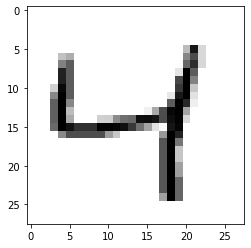

In [6]:
import matplotlib.pyplot as plt
plt.imshow(img.reshape(28,28), cmap='gray_r')
plt.show()

Bingo! Doğru tahmin. Bu şekilde toplam doğru tahmin edilen resim sayısı kaç acaba?

In [7]:
print(correct_cnt)

1000


Hepsini doğru tahmin etmiş, beklediğimiz gibi.

Şimdi şu soruya odaklanalım; acaba bu sinir ağı training aşamasında hiç görmediği bir resim için doğru tahmin yapabilecek mi? Bu soruyu araştırmak için MNIST veri seti içinde train ettiğimiz ilk 1000 resim dışında bazı resimler alıp tahminlere bakacağız. Bu input ve output veri setlerine `x_test` ve `y_test` diyelim, aşağıdaki programda olduğu gibi hazır olarak bunlara erişebiliriz. Kodu tüm olarak baştan yazacağım; `x_train` ve `y_train` ile training yapıp `x_test` ve `y_test` ile predict yapıp sonuçları yazdıracağız.

In [8]:
import sys
import numpy as np
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
images, labels = (x_train[0:1000].reshape(1000,28*28)/255, y_train[0:1000])

one_hot_labels = np.zeros((len(labels), 10))
for i,l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels

test_images = x_test.reshape(len(x_test),28*28)/255
test_labels = np.zeros((len(y_test), 10))
for i,l in enumerate(y_test):
    test_labels[i][l] = 1

np.random.seed(1)
relu = lambda x:(x>=0)*x
relu2deriv = lambda x: x>=0
alpha, iterations, hidden_size, pixels_per_image, num_labels = 0.005, 350, 40, 784, 10

weights_0_1 = 0.2*np.random.random((pixels_per_image,hidden_size)) - 0.1
weights_1_2 = 0.2*np.random.random((hidden_size,num_labels)) - 0.1

for j in range(iterations):
    error, correct_cnt = 0.0, 0
    for i in range(len(images)):
        layer_0 = images[i:i+1]
        layer_1 = relu(np.dot(layer_0,weights_0_1))
        layer_2 = np.dot(layer_1,weights_1_2)

        error += np.sum((labels[i:i+1] - layer_2)**2)
        correct_cnt += int(np.argmax(layer_2) == np.argmax(labels[i:i+1]))

        layer_2_delta = (labels[i:i+1] - layer_2)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T)*relu2deriv(layer_1)
        weights_1_2 += alpha*layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha*layer_0.T.dot(layer_1_delta)

    sys.stdout.write("\r I:"+str(j)+ \
                     " Train-Err:" + str(error/float(len(images)))[0:5] +\
                     " Train-Acc:" + str(correct_cnt/float(len(images))))
    
    if (j % 10 == 0 or j == iterations-1):
        error, correct_cnt = 0.0, 0
        for i in range(len(test_images)):
            layer_0 = test_images[i:i+1]
            layer_1 = relu(np.dot(layer_0,weights_0_1))
            layer_2 = np.dot(layer_1,weights_1_2)

            error += np.sum((test_labels[i:i+1] - layer_2)**2)
            correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))
        sys.stdout.write(" Test-Err:" + str(error/float(len(test_images)))[0:5] +\
                         " Test-Acc:" + str(correct_cnt/float(len(test_images))))
        print()

 I:0 Train-Err:0.722 Train-Acc:0.537 Test-Err:0.601 Test-Acc:0.6488
 I:10 Train-Err:0.312 Train-Acc:0.901 Test-Err:0.420 Test-Acc:0.8114
 I:20 Train-Err:0.260 Train-Acc:0.937 Test-Err:0.414 Test-Acc:0.8111
 I:30 Train-Err:0.232 Train-Acc:0.946 Test-Err:0.417 Test-Acc:0.8066
 I:40 Train-Err:0.215 Train-Acc:0.956 Test-Err:0.426 Test-Acc:0.8019
 I:50 Train-Err:0.204 Train-Acc:0.966 Test-Err:0.437 Test-Acc:0.7982
 I:60 Train-Err:0.194 Train-Acc:0.967 Test-Err:0.448 Test-Acc:0.7921
 I:70 Train-Err:0.186 Train-Acc:0.975 Test-Err:0.458 Test-Acc:0.7864
 I:80 Train-Err:0.179 Train-Acc:0.979 Test-Err:0.466 Test-Acc:0.7817
 I:90 Train-Err:0.172 Train-Acc:0.981 Test-Err:0.474 Test-Acc:0.7758
 I:100 Train-Err:0.166 Train-Acc:0.984 Test-Err:0.482 Test-Acc:0.7706
 I:110 Train-Err:0.161 Train-Acc:0.984 Test-Err:0.489 Test-Acc:0.7686
 I:120 Train-Err:0.157 Train-Acc:0.986 Test-Err:0.496 Test-Acc:0.766
 I:130 Train-Err:0.153 Train-Acc:0.999 Test-Err:0.502 Test-Acc:0.7622
 I:140 Train-Err:0.149 Train-Acc

Gördüğünüz gibi training verisi üzerindeki tahminle (training accuracy) önceki denememizde olduğu gibi sürekli iyileşerek %100 doğruluğa ulaşıyor fakat test veri seti üzerindeki tahminle öyle değil, sadece %70.7 doğrulukla sone eriyor. Bu %70.7 değerine ***test doğruluğu*** (Test Accuracy) denir ve sinir ağımızın gerçek hayatta ne kadar iyi tahmin yapabildiğini gösterir; aslında önemli olan tek gösterge budur!

Peki test sonuçlarının bu kadar düşük olmasının sebebi nedir? Çünkü test veri setini ağımız daha önce hiç görmedi, öğrenme aşamasını farklı resimler üzerinde yaptı ve bu yeni veriler öncekilerden hafifçe farklı. Bu veri setindeki el yazması resimler hep aynı insanın kaleminden alınmış olsaydı test verileri train verilerine daha benzer olabilirdi ve dolayısıyla test sonuçları daha iyi olabilirdi fakat durum böyle değil; resimler farklı insanlar tarafından yazılmış rakamları gösteriyor.

Yukarıdaki sonuçlara bakarsanız şöyle bir şeyi farkedersiniz; ilk başlarda test doğruluğu tıpkı training doğruluğu gibi yükselerek ilerlemiş fakt ilk 20 iterasyonun sonrasında bu tredn değişmiş ve test doğruluğu azalmaya başlamış. Bu  durum *sinir ağı 20 iterasyondan sonra overfit olmuştur* olarak açıklanır ve bunu şöyle yorumlamalıyız; sinir ağımız training verilerinin üzerinden tekrar tekrar geçtikçe gereğinden fazla detay öğrenmeye başlamıştır ve test veri setinde de aynı detayları aramıştır, bulamayınca da doğru tahmin yapması zorlaşmıştır. Mesela bir resim üzerindeki tahminine bakalım.

[ 0.07685519 -0.03397867 -0.21446188  0.54674877  0.13210735 -0.26954304
 -0.04453175 -0.08035744  0.30837761  0.3032636 ]


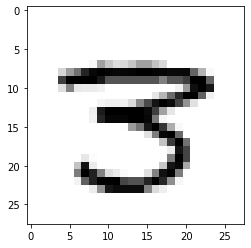

In [9]:
import matplotlib.pyplot as plt

test_img = test_images[3456]
hidden = relu(np.dot(test_img, weights_0_1))
predict = np.dot(hidden, weights_1_2)

print(predict)

plt.imshow(test_img.reshape(28,28), cmap='gray_r')
plt.show()

Görüldüğü gibi sinir ağı bu resmi 3 olarak tahmin etmiş ve doğru bir tahmin yapmış. Fakat tahminin olasılığı trainingte olduğu gibi yüksek değil; bunun 3 olma olasığını %55 olarak söylüyor. Ayrıca bu resmin 8 ve 9 rakamlarına da hatırı sayılır miktarda benzediğini söylüyor. Bşka bir örneğe bakalım.

[-0.01677989  0.00426485 -0.06886359  0.09969483  0.40293104  0.15647573
  0.00912401  0.04074101 -0.11665149  0.48605559]


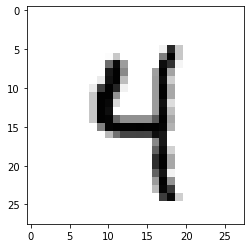

In [10]:
import matplotlib.pyplot as plt

test_img = test_images[170]
hidden = relu(np.dot(test_img, weights_0_1))
predict = np.dot(hidden, weights_1_2)

print(predict)

plt.imshow(test_img.reshape(28,28), cmap='gray_r')
plt.show()

Bu resim 4 rakamına ait fakat 9'a da benzerliği yüksek; mmuhtemelen `x_train` veri setinde 9'u 4'e benzer şekilde yazan insanlara ait resimlerle gereğinden fazla train olduğu için sinir ağı bunu 9 sanıyor, overfitting!!!

Bu gibi durumları engellemeliyiz, çünkü sinir ağımız gerçek hayat problemlerinde işe yaramazsa training aşamasındaki başarısının hiç bir anlamı yok. bunu engellemenin yolu sinir ağının training dataset içindeki gereksiz detayları görmemesini sağlamaktır, bu detaylar onu ezbere sürükler; ezber yerine daha genel inputlara da uyacak olan bir kural yakalamasını sağlamalıyız. Mesela kedi resimlerinden training yapıldığını düşünelim; çok sayıda kedi resminden sinir ağımızın odaklanması gereken yerler kediyi belirten bacak, kuyruk, kulak, kafa gibi uzuvlardır (bunlara makine öğrenmesi dilinde sinyal, ***signal***, denir). Kedi resimlerindeki tasma, kıyafet, oyuncak, ağaç, pencere, kapı gibi detayları sinir ağının ezberlememesi gerekir. bu gibi gereksiz detaylara makine öğrenmesi dilinde ***noise*** (parazit, gürültü, vs gibi çevrilebilir) denir. Şimdi bu gibi parazitleri görmezden gelip gerçek sinyallere daha çok odaklanmamızı sağlayan ve dolayısıyla overfit ile mücadele etmemizi sağlayan bazı ***regularization*** yöntemlerine değineceğim. Göreceksiniz ki bununla baş etmek sandığınız gibi karmaşık değil.

Sinir ağının iterasyonlar ilerledikçe istenmeyen detayları ezberlemesini engellemenin en kestirme yolu ağın öğrenmesini erkenden sonlandırmaktır. Sinir ağı overfit olmaya başladığı anda iterasyonu sonlandırırsak overfitting oluşmaz, eğer bu aşamadaki tahmin doğruluk değeri sizin için yeterlisyse bu bu regularization yöntemi çok etkili ve basittir. Peki kaç iterasyonda sonlandıracağımızı nasıl bileceğiz; deneyerek. Overfit olacak kadar yüksek bir iterasyon sayısı belirleyip ağımızı çalıştıracağız, overfit adımını gözlemleyip orada sonlandıracak şekilde iterasyon sayısını güncelleyeceğiz.

Fakat burada dikkat etmemiz gereken bir detay var, overfit tespiti için test veri seti dışında ***farklı*** bir input dataset kullanmalıyız, buna genellikle ***validation set*** denir. Sonuç olaraka üç farklı input datasete sahip olmalıyız; birisi training için, birisi validation (overfitting tespiti), diğeri de son aşama olan test için. Genel kural olarak test veri setini training işleminin hiç bir aşamasında kullanmamalıyız, bu veri seti ağımızın daha önce hiç görmediği bir veri seti olmalı.

Bir diğer regularization tekniği de ***dropout*** denilen tekniktir ve önerilen yöntem budur. Bu yöntem de çok basit bir mantığa dayanır; adından da anlaşılacağı gibi bu yöntemle training esnasında rastgele bazı nöron değerlerini 0 yaparız. Relu aktivasyonuna benzeyen bu yöntem ile sinir ağı boyutunu düşürmeden onun ezberlediği detayları azaltmış oluruz. Bazı değerler rastgele olarak susturulunca büyük sinir ağları küçükleri gibi davranır; iterasyonlar arttıkça kapasite artsa da overfitting oluşturacak detaylar susturulur. Aşağıdaki sinir ağında dropout uygulanıyor; bunun için `dropout_mask` denilen 0 ve 1'lerden oluşan bir matris üretip gizli katman ve ilgili delta değerini bununla çarparak rastgele elemanları siliyoruz, susturulan değerlerin toplam hataya katkısı olmayacağı için ilgili değerlerin delta sayılarını da susturuyoruz.

In [11]:
import sys
import numpy as np
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
images, labels = (x_train[0:1000].reshape(1000,28*28)/255, y_train[0:1000])

one_hot_labels = np.zeros((len(labels), 10))
for i,l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels

test_images = x_test.reshape(len(x_test),28*28)/255
test_labels = np.zeros((len(y_test), 10))
for i,l in enumerate(y_test):
    test_labels[i][l] = 1

relu = lambda x:(x>=0)*x
relu2deriv = lambda x: x>=0

alpha, iterations, hidden_size = 0.005, 300, 100
pixels_per_image, num_labels = 784, 10

weights_0_1 = 0.2*np.random.random((pixels_per_image, hidden_size)) - 0.1
weights_1_2 = 0.2*np.random.random((hidden_size, num_labels)) - 0.1

for j in range(iterations):
    error, correct_cnt = 0.0, 0
    for i in range(len(images)):
        layer_0 = images[i:i+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        dropout_mask = np.random.randint(2, size=layer_1.shape)
        layer_1 *= dropout_mask*2 ####
        layer_2 = np.dot(layer_1,weights_1_2)

        error += np.sum((labels[i:i+1] - layer_2)**2)
        correct_cnt += int(np.argmax(layer_2) == np.argmax(labels[i:i+1]))
        layer_2_delta = (labels[i:i+1] - layer_2)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T)*relu2deriv(layer_1)
        layer_1_delta *= dropout_mask

        weights_1_2 += alpha*layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha*layer_0.T.dot(layer_1_delta)

    if(j%10 == 0):
        test_error = 0.0
        test_correct_cnt = 0

        for i in range(len(test_images)):
            layer_0 = test_images[i:i+1]
            layer_1 = relu(np.dot(layer_0,weights_0_1))
            layer_2 = np.dot(layer_1, weights_1_2)

            test_error += np.sum((test_labels[i:i+1] - layer_2)**2)
            test_correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))

        sys.stdout.write("\n" + \
                         "I:" + str(j) + \
                         " Test-Err:" + str(test_error/ float(len(test_images)))[0:5] +\
                         " Test-Acc:" + str(test_correct_cnt/ float(len(test_images)))+\
                         " Train-Err:" + str(error/ float(len(images)))[0:5] +\
                         " Train-Acc:" + str(correct_cnt/ float(len(images))))


I:0 Test-Err:0.636 Test-Acc:0.6173 Train-Err:0.861 Train-Acc:0.418
I:10 Test-Err:0.451 Test-Acc:0.7988 Train-Err:0.480 Train-Acc:0.763
I:20 Test-Err:0.414 Test-Acc:0.8131 Train-Err:0.436 Train-Acc:0.805
I:30 Test-Err:0.409 Test-Acc:0.812 Train-Err:0.405 Train-Acc:0.829
I:40 Test-Err:0.415 Test-Acc:0.8054 Train-Err:0.390 Train-Acc:0.839
I:50 Test-Err:0.408 Test-Acc:0.8157 Train-Err:0.375 Train-Acc:0.85
I:60 Test-Err:0.394 Test-Acc:0.8153 Train-Err:0.357 Train-Acc:0.85
I:70 Test-Err:0.389 Test-Acc:0.8233 Train-Err:0.346 Train-Acc:0.869
I:80 Test-Err:0.394 Test-Acc:0.8181 Train-Err:0.347 Train-Acc:0.871
I:90 Test-Err:0.388 Test-Acc:0.8142 Train-Err:0.352 Train-Acc:0.875
I:100 Test-Err:0.387 Test-Acc:0.8172 Train-Err:0.342 Train-Acc:0.891
I:110 Test-Err:0.394 Test-Acc:0.8163 Train-Err:0.330 Train-Acc:0.878
I:120 Test-Err:0.386 Test-Acc:0.8193 Train-Err:0.329 Train-Acc:0.889
I:130 Test-Err:0.395 Test-Acc:0.8154 Train-Err:0.336 Train-Acc:0.892
I:140 Test-Err:0.386 Test-Acc:0.8172 Train-Err:

Gördüğünüz gibi dropout etkisi çok açık, test doğruluğu %82.64 tepe değerine ulaşabildi (100 iterasyonda), daha sonra overfit oldu ve %80.93'e kadar düştü. Daha önce dropout kullanmadan çalıştırdığımız sinir ağında en yüksek doğruluk değeri %81.14 tepe noktasına ulaştıktan sonra (20 iterasyonda) %70'lere kadar düşmüştü. Dropout ile overfitting olayını oldukça yavaşlattık, fakat bu yöntem training accuracy değerini de bir miktar düşürdü.

Dropout uygulamasında dikkatinizi çeken bir şey olmuştur; `layer_1` gizli katmanına droput uyguladıktan sonra bir de `2` ile çarparak büyüttük. Bunun sebebi şudur; **training aşamasında**bu katmanın değerlerinin **yarısını** dropout ile sildikten sonra bun tahmine ve toplam hataya etkisi yarı yarıya azalır, bu etkiyi kontrol edebilmek için ikiyle (yarsını sildiğimiz için) çarptık ve `layer_1` katmanının `layer_2` katmanına etkisini artırarak tekrar bir denge oluşturduk. Çünkü dropout işlemi sadece training aşamasında uygulanıyor, test aşamasında uygulanmaz!

Şimdi doğruluk değerinin daha hızlı yakınsamasına yardımcı olacak bir yöntemden bahsedeceğim; daha önce ***mini-batch gradient descent*** olayından kabaca bahsetmiştim. Bu yöntemle her bir iterasyonda weight değerlerini güncellemek yerine belirli bir sayıda iterasyonda (genelde 8 ile 256 arasında seçilir) ortalamaları alınarak güncelleme yapılır. Aşağıdaki program ***batch size*** değerini 100 alarak training yapıyor.

In [ ]:
import sys
import numpy as np
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
images, labels = (x_train[0:1000].reshape(1000,28*28)/255, y_train[0:1000])

one_hot_labels = np.zeros((len(labels), 10))
for i,l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels

test_images = x_test.reshape(len(x_test),28*28)/255
test_labels = np.zeros((len(y_test), 10))
for i,l in enumerate(y_test):
    test_labels[i][l] = 1

relu = lambda x:(x>=0)*x
relu2deriv = lambda x: x>=0

batch_size = 100
alpha, iterations = 0.001, 300
pixels_per_image, num_labels, hidden_size = 784, 10, 100

weights_0_1 = 0.2*np.random.random((pixels_per_image,hidden_size)) - 0.1
weights_1_2 = 0.2*np.random.random((hidden_size,num_labels)) - 0.1

for j in range(iterations):
    error, correct_cnt = 0.0, 0
    for i in range(int(len(images)/batch_size)):
        batch_start, batch_end = ((i*batch_size), ((i+1)*batch_size))

        layer_0 = images[batch_start:batch_end]
        layer_1 = relu(np.dot(layer_0,weights_0_1))
        dropout_mask = np.random.randint(2,size=layer_1.shape)
        layer_1 *= dropout_mask*2
        layer_2 = np.dot(layer_1,weights_1_2)

        error += np.sum((labels[batch_start:batch_end] - layer_2)**2)
        for k in range(batch_size):
            correct_cnt += int(np.argmax(layer_2[k:k+1]) == np.argmax(labels[batch_start+k:batch_start+k+1]))

            layer_2_delta = (labels[batch_start:batch_end]-layer_2)/batch_size
            layer_1_delta = layer_2_delta.dot(weights_1_2.T)*relu2deriv(layer_1)
            layer_1_delta *= dropout_mask

            weights_1_2 += alpha*layer_1.T.dot(layer_2_delta)
            weights_0_1 += alpha*layer_0.T.dot(layer_1_delta)
            
    if(j%10 == 0):
        test_error = 0.0
        test_correct_cnt = 0

        for i in range(len(test_images)):
            layer_0 = test_images[i:i+1]
            layer_1 = relu(np.dot(layer_0,weights_0_1))
            layer_2 = np.dot(layer_1, weights_1_2)

            test_error += np.sum((test_labels[i:i+1] - layer_2)**2)
            test_correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))

        sys.stdout.write("\n" + \
                         "I:" + str(j) + \
                         " Test-Err:" + str(test_error/ float(len(test_images)))[0:5] +\
                         " Test-Acc:" + str(test_correct_cnt/ float(len(test_images)))+\
                         " Train-Err:" + str(error/ float(len(images)))[0:5] +\
                         " Train-Acc:" + str(correct_cnt/ float(len(images))))


I:0 Test-Err:0.833 Test-Acc:0.366 Train-Err:1.311 Train-Acc:0.182
I:10 Test-Err:0.563 Test-Acc:0.7368 Train-Err:0.583 Train-Acc:0.693
I:20 Test-Err:0.512 Test-Acc:0.7544 Train-Err:0.535 Train-Acc:0.741
I:30 Test-Err:0.486 Test-Acc:0.7585 Train-Err:0.498 Train-Acc:0.765
I:40 Test-Err:0.468 Test-Acc:0.7679 Train-Err:0.484 Train-Acc:0.751
I:50 Test-Err:0.456 Test-Acc:0.7757 Train-Err:0.456 Train-Acc:0.78
I:60 Test-Err:0.446 Test-Acc:0.787 Train-Err:0.446 Train-Acc:0.805
I:70 Test-Err:0.440 Test-Acc:0.7968 Train-Err:0.446 Train-Acc:0.807
I:80 Test-Err:0.434 Test-Acc:0.8028 Train-Err:0.426 Train-Acc:0.804
I:90 Test-Err:0.430 Test-Acc:0.8062 Train-Err:0.431 Train-Acc:0.805
I:100 Test-Err:0.429 Test-Acc:0.803 Train-Err:0.424 Train-Acc:0.819
I:110 Test-Err:0.427 Test-Acc:0.8134 Train-Err:0.416 Train-Acc:0.819
I:120 Test-Err:0.431 Test-Acc:0.8092 Train-Err:0.411 Train-Acc:0.82
I:130 Test-Err:0.434 Test-Acc:0.8123 Train-Err:0.418 Train-Acc:0.839
I:140 Test-Err:0.435 Test-Acc:0.8114 Train-Err:0.

Gördüğünüz gibi yakınsama daha yavaş gibi görülse de weight değerlerinin ortalamalarını alarak güncellenmesi yakınsamayı daha düzgün bir hale getirdi. Burada dikkatinizi çeken ilk şey bu training aşamasının daha hızlı olduğudur, çünkü 100 iterasyonda bir `dot` işlemi yapılıyor ve CPU'lar bunu daha çok sever. Ayrıca şuna da dikkat edin; burada alpha değerini öncekine göre 20 kat daha büyük seçtik. Weight değerlerinin ortalamalarını aldığımız için bu işe yarayabilir, genelde batch yaparken bu değer büyütülür.